<a href="https://colab.research.google.com/github/pinakjani/ArmBench/blob/main/ARMBench_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
import sys

In [ ]:
!wget https://armbench-dataset.s3.amazonaws.com/segmentation/armbench-segmentation-0.1.tar.gz


--2023-05-15 01:47:02--  https://armbench-dataset.s3.amazonaws.com/segmentation/armbench-segmentation-0.1.tar.gz
Resolving armbench-dataset.s3.amazonaws.com (armbench-dataset.s3.amazonaws.com)... 52.216.215.105, 52.217.68.36, 54.231.164.201, ...
Connecting to armbench-dataset.s3.amazonaws.com (armbench-dataset.s3.amazonaws.com)|52.216.215.105|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19814367023 (18G) [application/x-gzip]
Saving to: ‘armbench-segmentation-0.1.tar.gz’

armbench-segmentati 100%[===================>]  18.45G  61.7MB/s    in 5m 10s  

2023-05-15 01:52:12 (61.0 MB/s) - ‘armbench-segmentation-0.1.tar.gz’ saved [19814367023/19814367023]



In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon May 15 01:52:12 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!tar -xzf "/content/armbench-segmentation-0.1.tar.gz"

In [ ]:
print('Mix-object Image Data' , len(os.listdir('/content/armbench-segmentation-0.1/mix-object-tote/images')))
print('Same-Object Image Data' , len(os.listdir('/content/armbench-segmentation-0.1/same-object-transfer-set/images')))
print('Zoomed-out-tote Image Data' , len(os.listdir('/content/armbench-segmentation-0.1/zoomed-out-tote-transfer-set/images')))

Mix-object Image Data 44251
Same-Object Image Data 3323
Zoomed-out-tote Image Data 5837


In [ ]:
mix_object_path = os.listdir('/content/armbench-segmentation-0.1/mix-object-tote/images')

In [ ]:
import os
import torch
import torch.utils.data
import torchvision
from PIL import Image
from pycocotools.coco import COCO

In [ ]:

class ARMBench(torch.utils.data.Dataset):
    def __init__(self, root, annotation, transforms=None):
        self.root = root
        self.transforms = transforms
        self.coco = COCO(annotation)
        self.ids = list(sorted(self.coco.imgs.keys()))

    def __getitem__(self, index):
        # Own coco file
        coco = self.coco
        # Image ID
        img_id = self.ids[index]
        # List: get annotation id from coco
        ann_ids = coco.getAnnIds(imgIds=img_id)
        # Dictionary: target coco_annotation file for an image
        coco_annotation = coco.loadAnns(ann_ids)
        # path for input image
        path = coco.loadImgs(img_id)[0]['file_name']
        # open the input image
        img = Image.open(os.path.join(self.root, path))

        # number of objects in the image
        num_objs = len(coco_annotation)

        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        boxes = []
        for i in range(num_objs):
            xmin = coco_annotation[i]['bbox'][0]
            ymin = coco_annotation[i]['bbox'][1]
            xmax = xmin + coco_annotation[i]['bbox'][2]
            ymax = ymin + coco_annotation[i]['bbox'][3]
            boxes.append([xmin, ymin, xmax, ymax])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # Labels (In my case, I only one class: target class or background)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        # Tensorise img_id
        img_id = torch.tensor([img_id])
        # Size of bbox (Rectangular)
        areas = []
        for i in range(num_objs):
            areas.append(coco_annotation[i]['area'])
        areas = torch.as_tensor(areas, dtype=torch.float32)
        # Iscrowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Annotation is in dictionary format
        my_annotation = {}
        my_annotation["boxes"] = boxes
        my_annotation["labels"] = labels
        my_annotation["image_id"] = img_id
        my_annotation["area"] = areas
        my_annotation["iscrowd"] = iscrowd

        if self.transforms is not None:
            img = self.transforms(img)

        return img, my_annotation

    def __len__(self):
        return len(self.ids)

##*Do* Changes Here

In [ ]:

class ARMBench(torch.utils.data.Dataset):
    def __init__(self, root, annotation, transforms=None):
        self.root = root
        self.transforms = transforms
        self.coco = COCO(annotation)
        self.ids = list(sorted(self.coco.imgs.keys()))
        # self.cat_ids = cat_ids

    def __getitem__(self, index):
        # Own coco file
        coco = self.coco
        # Image ID
        img_id = self.ids[index]
        # List: get annotation id from coco
        ann_ids = coco.getAnnIds(imgIds=img_id)
        # Dictionary: target coco_annotation file for an image
        coco_annotation = coco.loadAnns(ann_ids)
        #  List: get cat id from coco
        cat_ids = coco.getCatIds()
        # print(cat_ids)
        # path for input image
        path = coco.loadImgs(img_id)[0]['file_name']
        # open the input image
        img = Image.open(os.path.join(self.root, path))
        # create mask
        mask = np.stack([coco.annToMask(ann) * ann["category_id"] for ann in coco_annotation])
        
        obj_ids = np.unique(mask)
        obj_ids = obj_ids[1:]
        # print(obj_ids)
        mask = np.where(mask>0,1,0)
        # print(mask.shape)


        # masks = mask == obj_ids[:, None, None]

        # print("prev:",masks.shape)
        masks = mask.transpose((1,2,0))
        # print("now:",masks.shape)




        # number of objects in the image
        num_objs = len(coco_annotation)

        # print(num_objs,obj_ids)

        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        boxes = []
        for i in range(num_objs):
            xmin = coco_annotation[i]['bbox'][0]
            ymin = coco_annotation[i]['bbox'][1]
            xmax = xmin + coco_annotation[i]['bbox'][2]
            ymax = ymin + coco_annotation[i]['bbox'][3]
            boxes.append([xmin, ymin, xmax, ymax])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # Labels (In my case, I only one class: target class or background)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        # Tensorise img_id
        img_id = torch.tensor([img_id])
        # Size of bbox (Rectangular)
        areas = []
        for i in range(num_objs):
            areas.append(coco_annotation[i]['area'])
        areas = torch.as_tensor(areas, dtype=torch.float32)
        # Iscrowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # masks = torch.as_tensor(masks, dtype=torch.uint8)

        # print(masks.shape)


        # Annotation is in dictionary format
        my_annotation = {}
        my_annotation["boxes"] = boxes
        my_annotation["labels"] = labels
        my_annotation["image_id"] = img_id
        my_annotation["area"] = areas
        my_annotation["iscrowd"] = iscrowd

        # print(type(my_annotation))
        if self.transforms is not None:
            img = self.transforms(img)
            masks = self.transforms(masks)
        # print(type(my_annotation))
        my_annotation["masks"] = masks



        return img, my_annotation

    def __len__(self):
        return len(self.ids)

In [ ]:
from torchvision.transforms import functional as F
import random

def _flip_coco_person_keypoints(kps, width):
    flip_inds = [0, 2, 1, 4, 3, 6, 5, 8, 7, 10, 9, 12, 11, 14, 13, 16, 15]
    flipped_data = kps[:, flip_inds]
    flipped_data[..., 0] = width - flipped_data[..., 0]
    # Maintain COCO convention that if visibility == 0, then x, y = 0
    inds = flipped_data[..., 2] == 0
    flipped_data[inds] = 0
    return flipped_data


class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target


class RandomHorizontalFlip(object):
    def __init__(self, prob):
        self.prob = prob

    def __call__(self, image, target):
        if random.random() < self.prob:
            height, width = image.shape[-2:]
            image = image.flip(-1)
            bbox = target["boxes"]
            bbox[:, [0, 2]] = width - bbox[:, [2, 0]]
            target["boxes"] = bbox
            if "masks" in target:
                target["masks"] = target["masks"].flip(-1)
            if "keypoints" in target:
                keypoints = target["keypoints"]
                keypoints = _flip_coco_person_keypoints(keypoints, width)
                target["keypoints"] = keypoints
        return image, target


class ToTensor(object):
    def __call__(self, image, target):
        image = F.to_tensor(image)
        return image, target


KeyboardInterrupt: ignored

In [ ]:
def get_transform_new(train):
  transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
  transforms.append(Resize(size = (512,612)))
  transforms.append(ToTensor())
  if train:
      # during training, randomly flip the training images
      # and ground-truth for data augmentation
      transforms.append(RandomHorizontalFlip(0.5))
  return Compose(transforms)

In [ ]:
# In my case, just added ToTensor
def get_transform():
    custom_transforms = []
    custom_transforms.append(torchvision.transforms.ToTensor())
    # custom_transforms.append(torchvision.transforms.Resize(size = (512,612)))

    return torchvision.transforms.Compose(custom_transforms)

In [ ]:
# path to your own data and coco file
train_data_dir = '/content/armbench-segmentation-0.1/mix-object-tote/images'
train_armbench = '/content/armbench-segmentation-0.1/mix-object-tote/test.json'

# create own Dataset
dataset = ARMBench(root=train_data_dir,
                          annotation=train_armbench,
                          transforms=get_transform())

# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))

# Batch size
train_batch_size = 5

# own DataLoader
train_dataloader = torch.utils.data.DataLoader(dataset,
                                          batch_size=train_batch_size,
                                          shuffle=True,
                                          collate_fn=collate_fn)

loading annotations into memory...
Done (t=1.35s)
creating index...
index created!


In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
np.set_printoptions(threshold=None)


In [ ]:
images,labels = next(iter(train_dataloader))
a = labels[0]["masks"].numpy()
a = a[1]
print(a.shape)
print("see",images[0].shape)
print("see2",labels[0]["masks"].shape)
plt.imshow(a)
print(a[a>0])
# imshow(images[0], normalize=False);
# plt.imshow(images[0].numpy().transpose((1,2,0)))

NameError: ignored

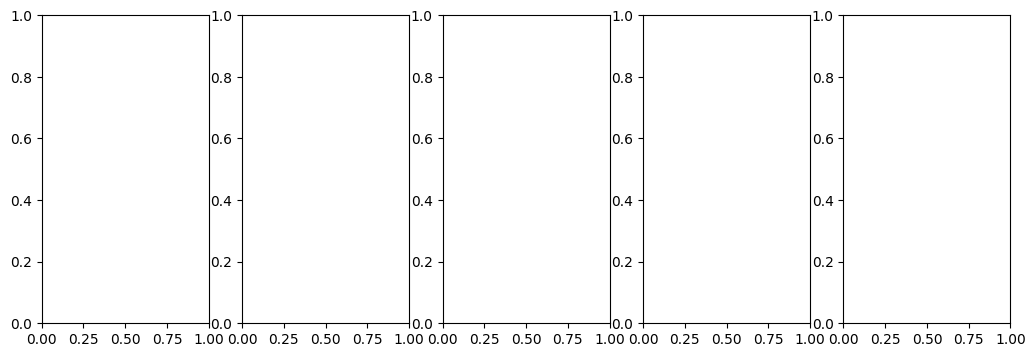

In [ ]:
# for loader_str, loader in [('Train Image', trainloader), 
#                            ('Test Image', testloader)]:
loader_str = "Test Image"
# data_iter = iter(train_dataloader)

# images, labels = next(data_iter)

ncol = 5
fig, axes = plt.subplots(figsize=(12.5,4), 
                          ncols=ncol)
for ii in range(ncol):
    ax = axes[ii]
    imshow(imgs[ii], 
            ax=ax, 
            normalize=False)
    ax.set_title('{} {}'.format(loader_str, ii+1))

In [ ]:
print(len(train_dataloader))


1321


In [ ]:
# with torch.no_grad():
torch.cuda.empty_cache()

In [ ]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [ ]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from tqdm import tqdm
PATH = "model5.pt"


# def get_model_instance_segmentation(num_classes):
#     # load an instance segmentation model pre-trained pre-trained on COCO
#     model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
#     # get number of input features for the classifier
#     in_features = model.roi_heads.box_predictor.cls_score.in_features
#     # replace the pre-trained head with a new one
#     model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

#     return model
    

# 2 classes; Only target class or background
num_classes = 2
num_epochs = 1
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)
    
# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                              #  step_size=3,
                                              #  gamma=0.1)

len_dataloader = len(train_dataloader)

for epoch in tqdm(range(num_epochs)):
  # torch.save(model.state_dict(), PATH)

  #   checkpoint = torch.load(PATH)
  #   model.load_state_dict(checkpoint['model_state_dict'])
  #   optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  #   epoch = checkpoint['epoch']
  #   loss = checkpoint['loss']
    model.train()
    i = 0    
    for imgs, annotations in train_dataloader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations)
        # print(loss_dict)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        # lr_scheduler.step()
        torch.cuda.empty_cache()
        if i==100:
            break

        print(f'Iteration: {i}/{len_dataloader}, Loss: {losses}')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/1 [00:00<?, ?it/s]

Iteration: 1/1321, Loss: 7.7037034034729
Iteration: 2/1321, Loss: 3.4113869667053223
Iteration: 3/1321, Loss: 1.8141967058181763
Iteration: 4/1321, Loss: 1.9064775705337524
Iteration: 5/1321, Loss: 2.180878162384033
Iteration: 6/1321, Loss: 2.065349817276001
Iteration: 7/1321, Loss: 1.6464850902557373
Iteration: 8/1321, Loss: 1.13693106174469
Iteration: 9/1321, Loss: 1.9378509521484375
Iteration: 10/1321, Loss: 2.330604314804077
Iteration: 11/1321, Loss: 1.5461393594741821
Iteration: 12/1321, Loss: 1.4173792600631714
Iteration: 13/1321, Loss: 1.1927299499511719
Iteration: 14/1321, Loss: 1.1385680437088013
Iteration: 15/1321, Loss: 1.676838994026184
Iteration: 16/1321, Loss: 1.2091678380966187
Iteration: 17/1321, Loss: 1.589246153831482
Iteration: 18/1321, Loss: 1.799964189529419
Iteration: 19/1321, Loss: 1.420198678970337
Iteration: 20/1321, Loss: 2.016117811203003
Iteration: 21/1321, Loss: 1.7651581764221191
Iteration: 22/1321, Loss: 1.1931893825531006
Iteration: 23/1321, Loss: 1.5659

100%|██████████| 1/1 [17:25<00:00, 1045.55s/it]


In [ ]:
torch.save(model, PATH)


In [ ]:
from google.colab import files
files.download(PATH)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model = torch.load("model4.pt")

In [ ]:
!nvidia-smi


Thu Apr 27 23:45:38 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    27W /  70W |   2977MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
torch.save(model, PATH)


In [ ]:
transform  = get_transform()

In [ ]:
trial = Image.open("/content/temp.jpg")
img1 = transform(trial) 
# print(img1.shape)

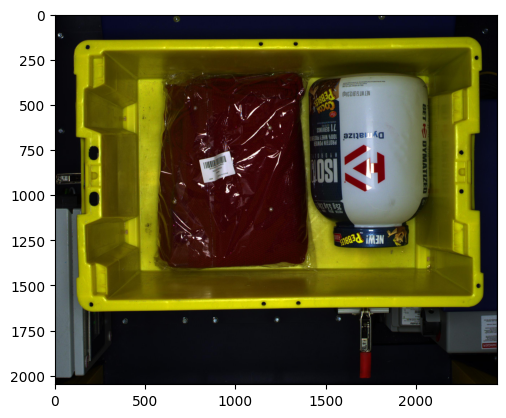

In [ ]:
plt.imshow(trial)

In [ ]:
image = Image.open("/content/temp.jpg")
model.eval()

# orig_image = image.copy()
image = np.array(image).astype(np.float32)

# BGR to RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
# make the pixel range between 0 and 1
image /= 255.0
# bring color channels to front
image = np.transpose(image, (2, 0, 1)).astype(np.float)
# convert to tensor
image = torch.tensor(image, dtype=torch.float).cuda()
# add batch dimension
image = torch.unsqueeze(image, 0)
with torch.no_grad():
    outputs = model(image)

<ipython-input-115-9e310a2a2a97>:12: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  image = np.transpose(image, (2, 0, 1)).astype(np.float)


In [ ]:
outputs[0]

{'boxes': tensor([[1387.1368,  308.7794, 2117.5254, 1205.7653],
         [ 568.0034,  269.1963, 1448.0933, 1439.2003],
         [1543.1428, 1150.2942, 1965.8661, 1299.4285],
         [ 225.8425,  139.4688, 2374.4675, 1627.9001],
         [1057.1610,  231.2356, 2285.0437, 1436.1161],
         [1405.8798,  342.3357, 1598.1503, 1123.6930],
         [ 796.8206,  730.2547,  998.6628,  950.1103],
         [ 560.4965,  402.9273,  695.2656, 1403.3784],
         [ 564.9154,  937.6879,  885.3437, 1419.7687],
         [ 539.4990,  404.5305,  925.9580, 1400.4221],
         [1359.1472, 1102.5961, 1452.1599, 1422.5208],
         [1999.6469, 1015.9451, 2064.6228, 1107.0862],
         [2029.9734,  462.5543, 2084.2654, 1072.0743],
         [1409.0562,  355.5261, 1580.4929,  558.9336],
         [ 106.3549,  223.9861,  557.5123, 1529.8059],
         [1376.4926, 1250.6262, 1448.7070, 1416.4800],
         [ 802.3535,  666.2859, 1040.9633, 1355.8077],
         [ 962.0566,  386.2702, 1432.3163, 1421.3173],
 

In [ ]:
def draw_segmentation(image,outputs):
  detection_threshold = 0.7
  # load all detection to CPU for further operations
  img = (image.cpu().numpy()).transpose((1, 2, 0))
  print(img.shape)
  img2 = img.copy()
  outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]
  # carry further only if there are detected boxes
  if len(outputs[0]['boxes']) != 0:
      boxes = outputs[0]['boxes'].data.numpy()
      scores = outputs[0]['scores'].data.numpy()
      # filter out boxes according to `detection_threshold`
      boxes = boxes[scores >= detection_threshold].astype(np.int32)
      draw_boxes = boxes.copy()
      # get all the predicited class names
      # pred_classes = [CLASSES[i] for i in outputs[0]['labels'].cpu().numpy()]
      
      # draw the bounding boxes and write the class name on top of it
      for j, box in enumerate(draw_boxes):
          cv2.rectangle(img2,
                      (int(box[0]), int(box[1])),
                      (int(box[2]), int(box[3])),
                      (0, 0, 255), 4)
          # cv2.putText(img1, pred_classes[j], 
          #             (int(box[0]), int(box[1]-5)),
          #             cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 
          #             2, lineType=cv2.LINE_AA)

  return img2

In [ ]:
a = outputs[0]["masks"]
print(a.shape)

torch.Size([58, 1, 2048, 2448])


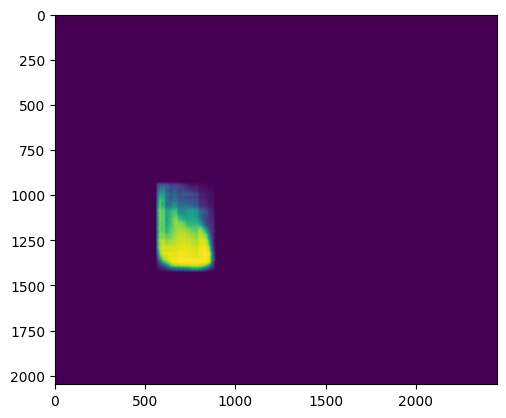

In [ ]:
plt.imshow((outputs[0]["masks"][8]*255).cpu().numpy().transpose((1, 2, 0)))

(2048, 2448, 3)


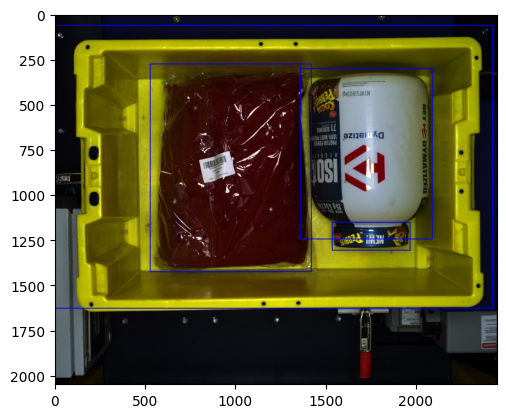

In [ ]:
look = draw_segmentation(img1,outputs)
plt.imshow(look)

In [ ]:
outputs[0]["masks"][:].cpu().numpy().shape

(30, 1, 2048, 2448)

In [ ]:
plt.imshow(outputs[0]["masks"][56].cpu().numpy().transpose((1, 2, 0)))

IndexError: ignored

In [ ]:

import random
def draw_segmentation_map(image, boxes,masks, labels,scores):
    image = (image.cpu().numpy()).transpose((1, 2, 0))
    print("look",masks[0].shape)
    print("image",image.shape)
    masks = (masks.cpu().numpy())
    boxes = boxes.cpu().numpy()
    scores = scores.cpu().numpy()
    labels = labels.cpu().numpy()
    COLORS = np.random.uniform(0, 255, size=(2, 3))
    alpha = 1 
    beta = 0.6 # transparency for the segmentation map
    gamma = 0 # scalar added to each sum
    # a = masks[scores >= 0.7]
    # print(a.shape)
    # plt.imshow(a[3].transpose(1,2,0))       


    for i in range(len(boxes)):
        red_map = np.zeros_like(masks[i]).astype(np.uint8)
        green_map = np.zeros_like(masks[i]).astype(np.uint8)
        blue_map = np.zeros_like(masks[i]).astype(np.uint8)

        # apply a randon color mask to each object
        color = COLORS[random.randrange(0, len(COLORS))]
        red_map[masks[i] == 1], green_map[masks[i] == 1], blue_map[masks[i] == 1]  = color
        # print("ji",red_map.shape)
        # combine all the masks into a single image
        segmentation_map = np.vstack([red_map, green_map, blue_map])
        segmentation_map = segmentation_map.transpose((1,2,0))
        segmentation_map = np.asarray(segmentation_map,np.float64)
        # print(segmentation_map[segmentation_map>0])
        #convert the original PIL image into NumPy format
        image = np.asarray(image,np.float64)
        # convert from RGN to OpenCV BGR format
        # image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        # apply mask on the image
        image = cv2.addWeighted(image, alpha, segmentation_map, beta, gamma)

        # draw the bounding boxes around the objects
        # print(boxes[i][0])
        cv2.rectangle(image, (int(boxes[i][0]), int(boxes[i][1])),(int(boxes[i][2]), int(boxes[i][3])), color=color, 
                      thickness=2)
        # put the label text above the objects
        # cv2.putText(image , "class", (boxes[i][0], boxes[i][0]-10), 
        #             cv2.FONT_HERSHEY_SIMPLEX, 1, color, 
        #             thickness=2, lineType=cv2.LINE_AA)
    
    return image

look torch.Size([1, 2048, 2448])
image (2048, 2448, 3)


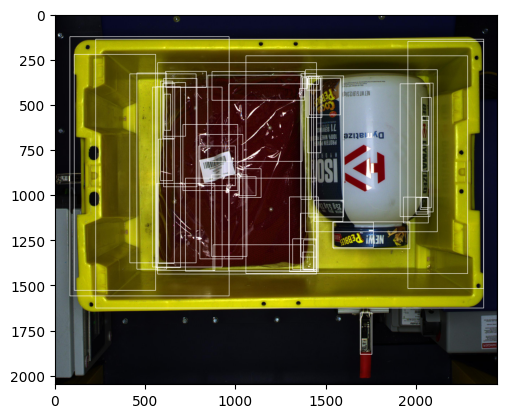

In [ ]:
mask = draw_segmentation_map(img1,outputs[0]['boxes'],outputs[0]['masks'],outputs[0]['labels'],outputs[0]["scores"])
# print(mask.shape)
plt.imshow(mask)

In [ ]:
def get_prediction(img_path, threshold=0.5, url=False):
  # if url: # We have to request the image
  #   response = requests.get(img_path)
  #   img = Image.open(BytesIO(response.content))
  # else:
  INSTANCE_CATEGORY_NAMES = ["Tote","Object"]
  img = Image.open(img_path) # This is for local images
  # transform = T.Compose([T.ToTensor()]) # Turn the image into a torch.tensor
  img = transform(img)
  img = img.cuda() # Only if GPU, otherwise comment this line
  pred = model([img]) # Send the image to the model. This runs on CPU, so its going to take time
  #Let's change it to GPU
  # pred = pred.cpu() # We will just send predictions back to CPU
  # Now we need to extract the bounding boxes and masks
  pred_score = list(pred[0]['scores'].detach().cpu().numpy())
  pred_t = [pred_score.index(x) for x in pred_score if x > threshold][-1]
  masks = (pred[0]['masks'] > 0.7).squeeze().detach().cpu().numpy()
  pred_class = [INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].cpu().numpy())]
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().cpu().numpy())]
  masks = masks[:pred_t+1]
  pred_boxes = pred_boxes[:pred_t+1]
  pred_class = pred_class[:pred_t+1]
  return masks, pred_boxes, pred_class

In [ ]:
def instance_segmentation(img_path, threshold=0.9, rect_th=3,
                          text_size=3, text_th=3, url=False):
  masks, boxes, pred_cls = get_prediction(img_path, threshold=threshold, url=url)
  if url:
    img = url_to_image(img_path) # If we have a url image
  else: # Local image
    img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # For working with RGB images instead of BGR
  for i in range(len(masks)):
    rgb_mask = random_color_masks(masks[i])
    img = cv2.addWeighted(img, 1, rgb_mask, 0.5, 0)
    pt1 = tuple(int(x) for x in boxes[i][0])
    pt2 = tuple(int(x) for x in boxes[i][1])
    cv2.rectangle(img, pt1, pt2, color=(0, 255, 0), thickness=rect_th)
    cv2.putText(img, pred_cls[i], pt1, cv2.FONT_HERSHEY_SIMPLEX, text_size, (0, 255, 0), thickness=text_th)
  return img, pred_cls, masks[i]

In [ ]:
def random_color_masks(image):
  # I will copy a list of colors here
  colors = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180], [250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  r[image==1], g[image==1], b[image==1] = colors[random.randrange(0, 10)]
  colored_mask = np.stack([r,g,b], axis=2)
  return colored_mask

In [ ]:
img, pred_classes, masks = instance_segmentation('test.jpg', rect_th=5, text_th=4)

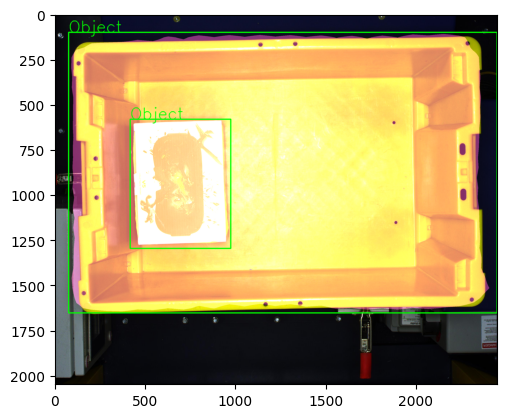

In [ ]:
plt.imshow(img)

In [ ]:

import matplotlib.pyplot as plt
import numpy as np

def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = (image.cpu().numpy()).transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.5, 0.5, 0.5])
        std = np.array([0.5, 0.5, 0.5])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax


In [ ]:

# DataLoader is iterable over Dataset
for imgs, annotations in train_dataloader:
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
    # print(annotations)